In [141]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, minmax_scale
from keras import layers
from keras.layers import Embedding, Dense, Merge, Dropout, Reshape, Flatten
from keras.models import Sequential
from keras.preprocessing.text import one_hot

In [142]:
df_user = pd.read_csv('users.csv')
df_business = pd.read_csv('business.csv')
df_review = pd.read_csv('train_reviews.csv')
# df_review.head()

In [143]:
# df_user = df_user[['user_id', 'average_stars', 'fans', 'funny', 'name', 'review_count', 'useful']]
# df_business = df_business[['business_id', 'address', 'attributes_Alcohol', 'attributes_BikeParking', 'attributes_BusinessAcceptsCreditCards', 'attributes_Caters', 'attributes_GoodForKids', 'attributes_HasTV', 'attributes_NoiseLevel', 'attributes_OutdoorSeating', 'latitude', 'longitude', 'review_count', 'stars']]
df_user = df_user[['user_id', 'average_stars', 'name']]
df_business = df_business[['business_id', 'address', 'review_count', 'stars']]
df_review = df_review[['user_id', 'business_id', 'stars']]

In [144]:
# df_review.drop_duplicates(subset=['user_id', 'business_id'], keep='first', inplace=True)
# print(len(df_review))

In [145]:
le = LabelEncoder()
df_user[['name']] = df_user[['name']].astype(str)
df_user['name'] = le.fit_transform(df_user['name'].values)
# df_business[['address', 'attributes_Alcohol', 'attributes_BikeParking', 'attributes_BusinessAcceptsCreditCards', \
#              'attributes_Caters', 'attributes_GoodForKids', 'attributes_HasTV', 'attributes_NoiseLevel', \
#              'attributes_OutdoorSeating']] \
# = df_business[['address', 'attributes_Alcohol', 'attributes_BikeParking', 'attributes_BusinessAcceptsCreditCards', \
#              'attributes_Caters', 'attributes_GoodForKids', 'attributes_HasTV', 'attributes_NoiseLevel', \
#              'attributes_OutdoorSeating']].astype(str)
# df_business[['address', 'attributes_Alcohol', 'attributes_BikeParking', 'attributes_BusinessAcceptsCreditCards', \
#              'attributes_Caters', 'attributes_GoodForKids', 'attributes_HasTV', 'attributes_NoiseLevel', \
#              'attributes_OutdoorSeating']]\
# = df_business[['address', 'attributes_Alcohol', 'attributes_BikeParking', 'attributes_BusinessAcceptsCreditCards', \
#              'attributes_Caters', 'attributes_GoodForKids', 'attributes_HasTV', 'attributes_NoiseLevel', \
#              'attributes_OutdoorSeating']].apply(le.fit_transform)
df_business[['address']] = df_business[['address']].astype(str).apply(le.fit_transform)


In [146]:
# df_user.set_index('user_id', inplace=True)
# df_business.set_index('business_id', inplace=True)
# minmax_scale(df_user.values)
# minmax_scale(df_business.values)

In [147]:
# df_user.reset_index(inplace=True)
# df_business.reset_index(inplace=True)
# df_user_train = pd.merge(df_user, df_review, how='inner', on=['user_id'])[['user_id', 'average_stars', 'fans', 'funny', 'name', 'review_count', 'useful']]
# df_business_train = pd.merge(df_business, df_review.drop(columns=['user_id', 'stars']), how='inner', on=['business_id'])
df_user_train = pd.merge(df_user, df_review.drop(columns=['business_id', 'stars']), how='inner', on=['user_id'])
df_business_train = pd.merge(df_business, df_review.drop(columns=['user_id', 'stars']), how='inner', on=['business_id'])

In [148]:
# df_user_train.set_index('user_id', inplace=True)
# df_business_train.set_index('business_id', inplace=True)
# df_user_train.head()
# df_business_train.head()

In [149]:
# train_user = minmax_scale(df_user_train.values)
# train_business =minmax_scale(df_business_train.values)

In [150]:
df_user_train['user_id'] = df_user_train['user_id'].astype('category').cat.codes.values
df_business_train['business_id'] = df_business_train['business_id'].astype('category').cat.codes.values

In [151]:
num_user = len(df_user_train['user_id'])
num_business = len(df_business_train['business_id'])
print(num_user)
print(num_business)

150232
150232


In [152]:
def my_model():
    k = 128
    model1 = Sequential()
    model1.add(Embedding(num_user + 1, k, input_length = 2))
    model1.add(Flatten())
    model2 = Sequential()
    model2.add(Embedding(num_business + 1, k, input_length = 3))
    model2.add(Flatten())

    model = Sequential()
    model.add(Merge([model1, model2], mode = 'concat'))
    model.add(Dropout(0.2))
    model.add(Dense(k, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(k/4), activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(int(k/16), activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation = 'relu'))
    return model

In [153]:
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = my_model()
model.compile(loss = 'mse', optimizer = "adam", metrics =[rmse])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()


In [154]:
X_train = [df_user_train[['user_id','average_stars']], df_business_train[['business_id', 'review_count', 'stars']]]
y_train = df_review['stars'].values

In [160]:
model.fit(X_train, y_train, batch_size = 100, epochs = 10)

Epoch 1/10
150232/150232 [==============================] - 748s 5ms/step - loss: 1.2136 - rmse: 1.0990
Epoch 2/10
150232/150232 [==============================] - 819s 5ms/step - loss: 1.2101 - rmse: 1.0973
Epoch 3/10
150232/150232 [==============================] - 797s 5ms/step - loss: 1.2085 - rmse: 1.0964
Epoch 4/10
150232/150232 [==============================] - 739s 5ms/step - loss: 1.2044 - rmse: 1.0948
Epoch 5/10
150232/150232 [==============================] - 2261s 15ms/step - loss: 1.2050 - rmse: 1.0948
Epoch 6/10
150232/150232 [==============================] - 746s 5ms/step - loss: 1.2012 - rmse: 1.0931
Epoch 7/10
150232/150232 [==============================] - 757s 5ms/step - loss: 1.2016 - rmse: 1.0933
Epoch 8/10
150232/150232 [==============================] - 773s 5ms/step - loss: 1.2011 - rmse: 1.0933
Epoch 9/10
150232/150232 [==============================] - 771s 5ms/step - loss: 1.2006 - rmse: 1.0930
Epoch 10/10
150232/150232 [==============================] - 8

In [ ]:
# df_user.set_index('user_id', inplace = True)
# df_business.set_index('business_id', inplace=True)

In [166]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_9 (Merge)              (None, 640)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 640)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               82048     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 264       
__________

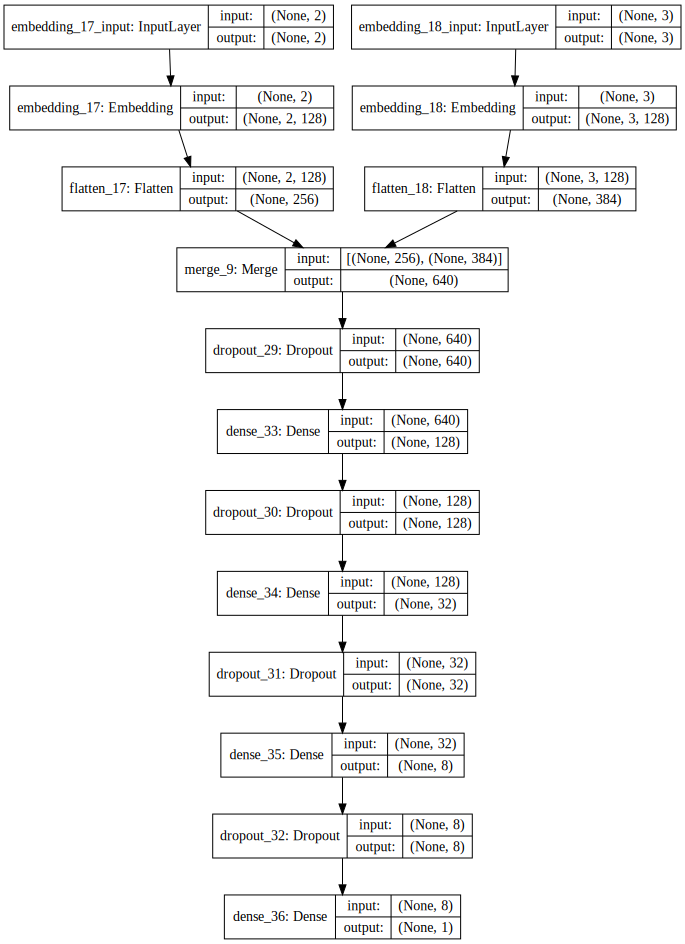

In [165]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

### validate

In [156]:
validate_queries = pd.read_csv('validate_queries.csv')
# validate_queries['user_id'] = validate_queries['user_id'].astype('category').cat.codes.values
# validate_queries['business_id'] = validate_queries['business_id'].astype('category').cat.codes.values

df_user_validate = pd.merge(df_user, validate_queries.drop(columns=['business_id', 'stars']), how='inner', on=['user_id'])
df_business_validate = pd.merge(df_business, validate_queries.drop(columns=['user_id', 'stars']), how='inner', on=['business_id'])
df_user_validate['user_id'] = df_user_validate['user_id'].astype('category').cat.codes.values
df_business_validate['business_id'] = df_business_validate['business_id'].astype('category').cat.codes.values

X_validate = [df_user_validate[['user_id', 'average_stars']], df_business_validate[['business_id', 'review_count', 'stars']]]
y_validate = validate_queries['stars']

In [161]:
y_validate_pred = np.rint(model.predict(X_validate))

In [93]:
print(y_validate_pred.shape)
print(y_validate.shape)

(50077, 1)
(50077,)


In [162]:
rmse_validate = np.sqrt(np.mean(np.square(y_validate_pred.reshape(y_validate_pred.shape[0],) - y_validate)))
print(rmse_validate)

1.3706374005545556


### Test

In [168]:
queries = pd.read_csv('test_queries.csv')
# queries['user_id'] = queries['user_id'].astype('category').cat.codes.values
# queries['business_id'] = queries['business_id'].astype('category').cat.codes.values
df_user_test = pd.merge(df_user, queries.drop(columns=['business_id']), how='inner', on=['user_id'])
df_business_test = pd.merge(df_business, queries.drop(columns=['user_id']), how='inner', on=['business_id'])
df_user_test['user_id'] = df_user_test['user_id'].astype('category').cat.codes.values
df_business_test['business_id'] = df_business_test['business_id'].astype('category').cat.codes.values

queries.head()

,user_id,business_id
0,XEDaNNCTVAqPpvyX2zY03g,e880MGw6C6PJL-n3EJoY_g
1,E9WotdbCBpoeID-DHSQh1A,ExLXL_oQvI7oPB7TrVpGhg
2,8erAzkOo9KHs1Njo5bMm_Q,XKQsxvDMe9rAWO0P0Uwx-Q
3,eHJTLVy1bm7zSGVQlNH6KA,awI4hHMfa7H0Xf0-ChU5hg
4,KF2L4CDnmPz6diaH6TrxbA,jKrlc4xQIvfzDZ8eNfqxwg


In [19]:
# df_user_test = df_user.loc[queries['user_id']]
# df_business_test = df_business.loc[queries['business_id']]
# df_user_test.head()
# df_business_test.head()

,business_id,address,attributes_Alcohol,attributes_BikeParking,attributes_BusinessAcceptsCreditCards,attributes_Caters,attributes_GoodForKids,attributes_HasTV,attributes_NoiseLevel,attributes_OutdoorSeating,latitude,longitude,review_count,stars
6948,OaM2Bjeo2Ftt84ruTrzPNQ,6949,3,0,1,1,1,0,3,1,33.347893,-111.976822,116,4.5
2632,4aF5GfnVkJPj9IwJ2yxPtQ,8885,1,1,1,0,0,1,0,1,33.423346,-111.941376,335,3.5
5654,vYKZHWBuBT1PUevggLAE9w,10123,3,1,1,1,1,1,3,1,33.421881,-111.925474,111,3.5
6396,O0UhNI9KHdY1wOdhEtT2vg,10523,3,1,1,1,1,1,0,1,33.711445,-112.273148,102,4.0
7806,kosTPb88O4Q0XGbVbEOGCA,8000,2,1,1,2,2,2,2,2,36.086364,-115.035941,113,4.0


In [169]:
X_test = [df_user_test[['user_id', 'average_stars']], df_business_test[['business_id', 'review_count', 'stars']]]


In [170]:
res = np.rint(model.predict(X_test))
# res[:100]

In [171]:
res_ = pd.DataFrame(res)

In [24]:
res_.to_csv('submit2.csv')